## Executive summary:
Overall, size and cost of solar panels for unseen data is predicted with R2~0.98, and R2~0.68 respectively (as expected from cv_scores and it's std. deviation from last notebook).

→ Knowing that this model performs well, we prdict size and cost of solar panel of uncle_bob and 3 other popular characters who want to switch to solar energy from traditional energy (based on their energy consumption and other feature values)

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Goal 1: Predict size of solar panels of unseen data based on RIDGE regression model saved in notebook 1

In [2]:
new_data = pd.read_csv('unseen_data.csv', usecols=['state', 'zipcode', 'installer', 'city', 'tech_1', 
                                               'county', 'annual_PV_prod', 'size_kw', 'cost'])
new_data.head()

,state,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,cost
0,CA,5.640000,92691,SolarCity,Mission Viejo,Poly,Orange,7786.386270,29384.4
1,CT,1.750000,6880,Encon,Westport,Mono,Fairfield,2292.929169,11200.0
2,CA,4.000000,95630,SolarCity,Folsom,Poly,Sacramento,5841.145508,19200.0
3,CA,5.830000,92675,SolarCity,SAN JUAN CAPO,Poly,Orange,8920.771084,29849.0
4,CA,8.582292,92392,Christianbelle Electric,VICTORVILLE,Mono,San Bernardino,15196.672860,38705.0


### Data preparation

In [3]:
# Reduce cardinality of new data based on train data
solar_train = pd.read_csv('solar_train.csv', usecols=['state', 'zipcode', 'installer', 'city', 'zipcode_1',
                                                'tech_1', 'county', 'annual_PV_prod', 'size_kw', 'cost'])
# Extract 1st number of zipcode
new_data['zipcode_1'] = new_data['zipcode'].astype('str').str[:1].astype(int)

# Check cardinality
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)
df, patterns, reduced_list, other = group_levels_in_categoricals(solar_train)

# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):   
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test
new_data = group_levels_in_categoricals_test(reduced_list, other, patterns, new_data)

In [4]:
# Feature engineering like train set in Notebook 1
solar_train['size_kw_L'] = np.log1p(solar_train['size_kw'])
new_data['size_kw_L'] = np.log1p(new_data['size_kw'])
solar_train['cost_L'] = np.log1p(solar_train['cost'])
new_data['cost_L'] = np.log1p(new_data['cost'])

solar_train['annual_PV_prod_L'] = np.log1p(solar_train['annual_PV_prod'])
new_data['annual_PV_prod_L'] = np.log1p(new_data['annual_PV_prod'])

solar_train['annual_PV_prod_L-s2'] = solar_train['annual_PV_prod_L']** 2
new_data['annual_PV_prod_L-s2'] = new_data['annual_PV_prod_L']** 2

solar_train['zipcode_1'] = solar_train['zipcode_1'].apply(str)
new_data['zipcode_1'] = new_data['zipcode_1'].apply(str)

# Categorical encoding
solar_train1 = pd.get_dummies(solar_train)
new_data1 = pd.get_dummies(new_data)

# Dependent variable
new_data_real_size = new_data['size_kw']
y = new_data[['size_kw_L']]
y1 = new_data['size_kw_L']

# Independent variables
solar_train1 = solar_train1.drop(columns=['size_kw', 'size_kw_L', 'cost', 'cost_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L'])                         
new_data1 = new_data1.drop(columns=['size_kw', 'size_kw_L', 'cost', 'cost_L','zipcode', 'annual_PV_prod', 'annual_PV_prod_L']) 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
solar_train_stndz1 = sc.fit_transform(solar_train1)
new_data_stndz1 = sc.transform(new_data1)

### Testing the ridge model on unseen data

In [5]:
from sklearn.externals import joblib
rg1 =joblib.load('size_prediction_model.joblib')
print(f'Saved ridge_model_r2 with new_data: {rg1.score(new_data_stndz1, y).round(4)}')

Saved ridge_model_r2 with new_data: 0.9852


**Plotting predicted and actual size of solar panels**

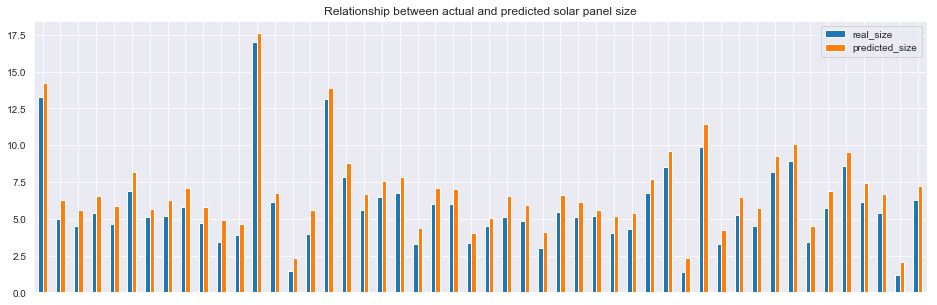

In [6]:
# Relationship between actual solar panel and predicted solar panel size (transformed)
fig, axes = plt.subplots(1,1, figsize = (16,5))
y_pred_actual = np.exp(rg1.predict(new_data_stndz1))
size_pred = pd.DataFrame({'real_size':new_data_real_size, 'predicted_size':y_pred_actual})
size_pred.sample(n=50).plot(kind='bar', ax=axes)
axes.set_title('Relationship between actual and predicted solar panel size')
axes.set_xticklabels('');

■ Prediction on real size of solar panels of unseen data is pretty accurate.

### Goal 2: Predict cost of solar panels of unseen data based on ML pipeline saved in notebook 1

In [7]:
# Dependent variable
new_data_real_cost = new_data['cost']
y = new_data[['cost_L']]
y1 = new_data['cost_L']

# Independent variables
solar_train2 = solar_train.drop(columns=['size_kw_L', 'cost', 'cost_L', 'zipcode', 'annual_PV_prod_L-s2', 'annual_PV_prod'])                         
new_data2 = new_data.drop(columns=['size_kw_L', 'cost', 'cost_L','zipcode', 'annual_PV_prod_L-s2', 'annual_PV_prod']) 

### Testing the ridge model (ML pipeline) on unseen data

In [8]:
from sklearn.externals import joblib
rg2 =joblib.load('cost_prediction_pipeline.joblib')
print(f'Saved ridge_model_r2 with new_data: {rg2.score(new_data2, y1).round(4)}')

Saved ridge_model_r2 with new_data: 0.6814


**Plotting predicted and actual cost of the solar panels**

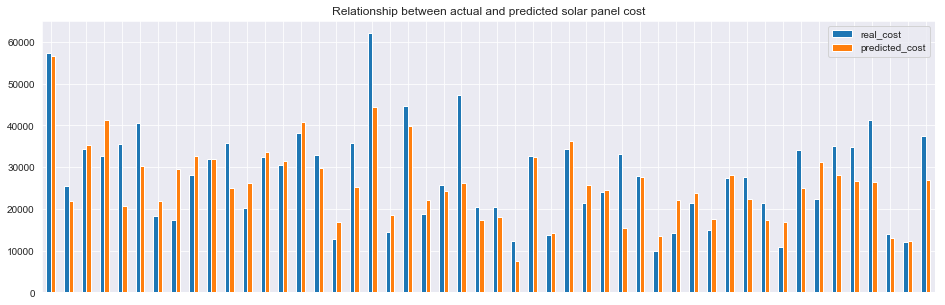

In [9]:
# Relationship between actual solar panel and predicted solar panel cost (transformed)
fig, axes = plt.subplots(1,1, figsize = (16,5))
y_pred_actual = np.exp(rg2.predict(new_data))
size_pred = pd.DataFrame({'real_cost':new_data_real_cost, 'predicted_cost':y_pred_actual})
size_pred.sample(n=50).plot(kind='bar', ax=axes)
axes.set_title('Relationship between actual and predicted solar panel cost')
axes.set_xticklabels('');

### Goal 3.A: Predicting size & cost of solar panels for Uncle_bob based on energy consumption & rest details

After getting electric bill for summer, Uncle Bob decides to opt for solar energy. He checks his power consumption and provides his details:
state= California (CA), installer=SolarCity, city=Los Angeles, tech_1=Poly, county=Los Angeles, annual power consumption=2700, zipcode=93444

**Can we find out what size of solar panels he need based on energy consumption and other details and what might be solar panel cost?**

**GOALS** <br>
**→ Predicting size of the solar panel uncle Bob need to install !** <br>
**→ Predicting cost of the solar panel uncle Bob need to install !** <br>
**→ Finding break even point for uncle bob to recover his investments!** <br>

In [10]:
# Widget and user information
def make_df(state, city, county, zipcode, installer, tech_1, annual_PV_prod): 
    df = pd.DataFrame([state, city, county, zipcode, installer, tech_1, annual_PV_prod]).T
    df.columns = ['state', 'city', 'county', 'zipcode', 'installer', 'tech_1', 'annual_PV_prod']    
    return df

from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual
from IPython.display import display
from termcolor import colored
p1 = interactive(make_df, state = [x for x in new_data['state'].unique()],
                 city = [x for x in new_data['city'].unique()],
                 county = [x for x in new_data['county'].unique()],
                 zipcode = [x for x in new_data['zipcode'].unique()],
                 installer = [x for x in new_data['installer'].unique()],
                 tech_1 = [x for x in new_data['tech_1'].unique()], 
                 annual_PV_prod = (100.0,65000.0,0.01))

def display_options(p1):
    print('■'*48, '\033[1m' + colored('User choice', 'red'), '■'*48,'\n')
    print('\033[1m' + colored('Fill fill up the following boxes:', 'blue'))
    print('■ Please select your State | City | County | Zipcode | Installer | Tech_1 | Annual energy consumption \n')
    print('More information on Installer and Tech_1: \n')
    print('→ Please select the installer: Installing company for solar panels. In case you are not aware of any, please select others\n')
    print('→ Please select tech_1 based on your knowledge or following description: Quality of solar panels')
    print('     ■ MONO: Most energy efficient, space-efficient and durable but most expensive solar panels')
    print('     ■ POLY: Less energy efficient, less space-efficient but relatively cheaper than POLY solar panels')
    print('     ■ CRYSTALLINE: Looks attractive, good option when space is not an issue, moderate efficiency and price \n')    
    return display(p1)

In [11]:
display_options(p1)

def solarpanel_size_cost_breakeven(name, inputs):
    uncle_bob = inputs.result
    cols = ['zipcode', 'annual_PV_prod']
    uncle_bob[cols] = uncle_bob[cols].apply(pd.to_numeric)
    
    # Extract 1st number of zipciode
    uncle_bob['zipcode_1'] = uncle_bob['zipcode'].astype('str').str[:1].astype(int)  
    new_data_ub = pd.read_csv('unseen_data.csv', usecols=['state','zipcode','installer', 'city', 'tech_1', 
                                                'county', 'annual_PV_prod', 'zipcode_1', 'size_kw', 'cost'])
    uncle_bob_test = new_data_ub.append(uncle_bob, ignore_index=True)
    solar_train_1 = pd.read_csv('solar_train.csv', usecols=['state','zipcode','installer', 'city', 'tech_1', 
                                                'county', 'annual_PV_prod', 'zipcode_1', 'size_kw', 'cost'])
    # Align columns
    uncle_bob_test = uncle_bob_test[solar_train_1.columns]
    # Cardinality
    df, patterns, reduced_list, other = group_levels_in_categoricals(solar_train_1)
    uncle_bob_test  = group_levels_in_categoricals_test(reduced_list, other, patterns, uncle_bob_test)
    # Feature engineering
    solar_train_1['size_kw_L'] = np.log1p(solar_train_1['size_kw'])
    uncle_bob_test['size_kw_L'] = np.log1p(uncle_bob_test['size_kw'])
    solar_train_1['annual_PV_prod_L'] = np.log1p(solar_train_1['annual_PV_prod'])
    uncle_bob_test['annual_PV_prod_L'] = np.log1p(uncle_bob_test['annual_PV_prod'])
    solar_train_1['annual_PV_prod_L-s2'] = solar_train_1['annual_PV_prod_L']** 2
    uncle_bob_test['annual_PV_prod_L-s2'] = uncle_bob_test['annual_PV_prod_L']** 2
    solar_train_1['zipcode_1'] = solar_train_1['zipcode_1'].apply(str)
    uncle_bob_test['zipcode_1'] = uncle_bob_test['zipcode_1'].apply(str)
    # Categorical encoding
    solar_train_2 = pd.get_dummies(solar_train_1)
    uncle_bob_test1 = pd.get_dummies(uncle_bob_test)

    # actual size of solar panels
    y = uncle_bob_test1['size_kw']
    y_new_data = y[:-1]
    # Drop columns
    uncle_bob_test1 = uncle_bob_test1.drop(columns=[ 'size_kw', 'size_kw_L', 'cost', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L']) 
    solar_train_2 = solar_train_2.drop(columns=[ 'size_kw', 'size_kw_L', 'zipcode',  'cost', 'annual_PV_prod', 'annual_PV_prod_L']) 
    # Scale data
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    solar_train_stndz_1 = sc.fit_transform(solar_train_2)
    uncle_bob_stndz = sc.transform(uncle_bob_test1)
    
    # Finding solar panel size
    uncle_bob_pred = np.exp(rg1.predict(uncle_bob_stndz))
    size_array = pd.DataFrame(uncle_bob_pred)
    df = pd.concat([uncle_bob_test, size_array], axis=1)
    df.rename(columns={0: 'predicted_size'}, inplace=True)
    
    # Cost of solar panels
    solar_train_1['cost_L'] = np.log1p(solar_train_1['cost'])
    uncle_bob_test['cost_L'] = np.log1p(uncle_bob_test['cost'])
    # Update solar panel size to predict cost
    uncle_bob_test['size_kw'] = df.iloc[-1,-1]
    # Drop columns
    uncle_bob_test2 = uncle_bob_test.drop(columns=[ 'size_kw_L', 'cost',  'cost_L', 'zipcode', 'annual_PV_prod', 'annual_PV_prod_L-s2']) 
    solar_train_3 = solar_train_1.drop(columns=[ 'size_kw_L', 'zipcode',  'cost', 'cost_L', 'annual_PV_prod', 'annual_PV_prod_L-s2'])
    # Predicitng cost
    uncle_bob_pred = np.exp(rg2.predict(uncle_bob_test2))
    size_array = pd.DataFrame(uncle_bob_pred)
    df = pd.concat([uncle_bob_test, size_array], axis=1)
    df['annual_PV_prod']  = np.exp(df['annual_PV_prod_L'])
    df.rename(columns={0: 'predicted_cost'}, inplace=True)
    
    # Break-even of the investment
    # Average cost of electricity is 20cents/kwh
    uncle_bob_traditional_cost = (6262.51*20)/100
    break_even = df.iloc[-1,-1] / uncle_bob_traditional_cost
    
    # Display
    print(f'======================================= Thanks for opting solar energy dear {name} ==================================')
    print('\n')
    print(f'■ {name} needs solar panel of size {df.iloc[-1,1].round(2)}kw to replace total annual traditional energy consumption of {df.iloc[-1,7].round(2)}kwh')
    print('\n')
    print(f'■ {name} needs to invest ${df.iloc[-1,-1].round(2)} to install solar panels of size {df.iloc[-1,1].round(2)}kw')
    print('\n')
    print(f'■ {name} needs {break_even.round(0)} years to break even for his investment to switch from traditional to solar energy.')
    df.index = [name]* len(df)
    return df.iloc[[-1],[7,1,-1]]

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ User choice ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 

Fill fill up the following boxes:
■ Please select your State | City | County | Zipcode | Installer | Tech_1 | Annual energy consumption 

More information on Installer and Tech_1: 

→ Please select the installer: Installing company for solar panels. In case you are not aware of any, please select others

→ Please select tech_1 based on your knowledge or following description: Quality of solar panels
     ■ MONO: Most energy efficient, space-efficient and durable but most expensive solar panels
     ■ POLY: Less energy efficient, less space-efficient but relatively cheaper than POLY solar panels
     ■ CRYSTALLINE: Looks attractive, good option when space is not an issue, moderate efficiency and price 



interactive(children=(Dropdown(description='state', options=('CA', 'CT', 'MA', 'MD', 'PA', 'NY', 'AZ', 'NJ', '…

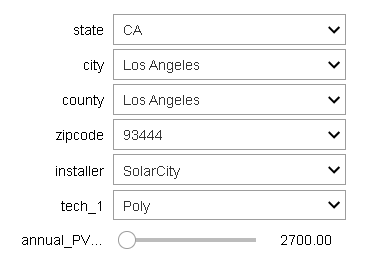

In [12]:
from IPython.display import Image, display
display(Image(filename='uncle_bob.png', embed=True))

In [13]:
Uncle_bob = solarpanel_size_cost_breakeven('Uncle bob', p1)
Uncle_bob

======================================= Thanks for opting solar energy dear Uncle bob ==================================


■ Uncle bob needs solar panel of size 2.77kw to replace total annual traditional energy consumption of 2701.0kwh


■ Uncle bob needs to invest $13325.18 to install solar panels of size 2.77kw


■ Uncle bob needs 11.0 years to break even for his investment to switch from traditional to solar energy.


,annual_PV_prod,size_kw,predicted_cost
Uncle bob,2701.0,2.773689,13325.18443


### Goal 3.B: Predicting size & cost of solar panels of Transformer-BumbleBee's house

In [14]:
p2 = interactive(make_df, state = [x for x in new_data['state'].unique()],
                 city = [x for x in new_data['city'].unique()],
                 county = [x for x in new_data['county'].unique()],
                 zipcode = [x for x in new_data['zipcode'].unique()],
                 installer = [x for x in new_data['installer'].unique()],
                 tech_1 = [x for x in new_data['tech_1'].unique()], 
                 annual_PV_prod = (100.0,65000.0,0.01))
display_options(p2)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ User choice ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 

Fill fill up the following boxes:
■ Please select your State | City | County | Zipcode | Installer | Tech_1 | Annual energy consumption 

More information on Installer and Tech_1: 

→ Please select the installer: Installing company for solar panels. In case you are not aware of any, please select others

→ Please select tech_1 based on your knowledge or following description: Quality of solar panels
     ■ MONO: Most energy efficient, space-efficient and durable but most expensive solar panels
     ■ POLY: Less energy efficient, less space-efficient but relatively cheaper than POLY solar panels
     ■ CRYSTALLINE: Looks attractive, good option when space is not an issue, moderate efficiency and price 



interactive(children=(Dropdown(description='state', options=('CA', 'CT', 'MA', 'MD', 'PA', 'NY', 'AZ', 'NJ', '…

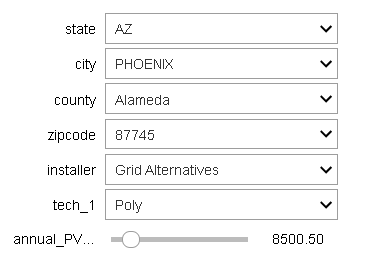

In [15]:
display(Image(filename='bumble_bee.png', embed=True))

In [16]:
Transformer_BumbleBee = solarpanel_size_cost_breakeven('Transformer-BumbleBee', p2)
Transformer_BumbleBee

======================================= Thanks for opting solar energy dear Transformer-BumbleBee ==================================


■ Transformer-BumbleBee needs solar panel of size 6.37kw to replace total annual traditional energy consumption of 8501.0kwh


■ Transformer-BumbleBee needs to invest $31318.05 to install solar panels of size 6.37kw


■ Transformer-BumbleBee needs 25.0 years to break even for his investment to switch from traditional to solar energy.


,annual_PV_prod,size_kw,predicted_cost
Transformer-BumbleBee,8501.0,6.365902,31318.053547


### Goal 3.C: Predicting size & cost of solar panels of Captain America's house

In [17]:
p3 = interactive(make_df, state = [x for x in new_data['state'].unique()],
                 city = [x for x in new_data['city'].unique()],
                 county = [x for x in new_data['county'].unique()],
                 zipcode = [x for x in new_data['zipcode'].unique()],
                 installer = [x for x in new_data['installer'].unique()],
                 tech_1 = [x for x in new_data['tech_1'].unique()], 
                 annual_PV_prod = (100.0,65000.0,0.01))
display_options(p3)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ User choice ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 

Fill fill up the following boxes:
■ Please select your State | City | County | Zipcode | Installer | Tech_1 | Annual energy consumption 

More information on Installer and Tech_1: 

→ Please select the installer: Installing company for solar panels. In case you are not aware of any, please select others

→ Please select tech_1 based on your knowledge or following description: Quality of solar panels
     ■ MONO: Most energy efficient, space-efficient and durable but most expensive solar panels
     ■ POLY: Less energy efficient, less space-efficient but relatively cheaper than POLY solar panels
     ■ CRYSTALLINE: Looks attractive, good option when space is not an issue, moderate efficiency and price 



interactive(children=(Dropdown(description='state', options=('CA', 'CT', 'MA', 'MD', 'PA', 'NY', 'AZ', 'NJ', '…

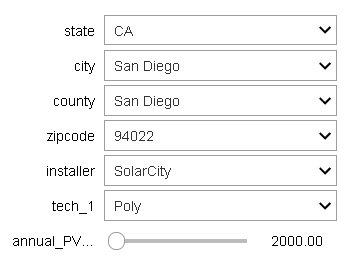

In [18]:
display(Image(filename='Cap_America.png', embed=True))

In [19]:
Captain_America = solarpanel_size_cost_breakeven('Captain America', p3)
Captain_America

======================================= Thanks for opting solar energy dear Captain America ==================================


■ Captain America needs solar panel of size 2.22kw to replace total annual traditional energy consumption of 2001.0kwh


■ Captain America needs to invest $10990.91 to install solar panels of size 2.22kw


■ Captain America needs 9.0 years to break even for his investment to switch from traditional to solar energy.


,annual_PV_prod,size_kw,predicted_cost
Captain America,2001.0,2.21597,10990.91235


### Goal 3.D: Predicting size & cost of solar panels of Thanos's house

In [20]:
p4 = interactive(make_df, state = [x for x in new_data['state'].unique()],
                 city = [x for x in new_data['city'].unique()],
                 county = [x for x in new_data['county'].unique()],
                 zipcode = [x for x in new_data['zipcode'].unique()],
                 installer = [x for x in new_data['installer'].unique()],
                 tech_1 = [x for x in new_data['tech_1'].unique()], 
                 annual_PV_prod = (100.0,65000.0,0.01))
display_options(p4)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ User choice ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 

Fill fill up the following boxes:
■ Please select your State | City | County | Zipcode | Installer | Tech_1 | Annual energy consumption 

More information on Installer and Tech_1: 

→ Please select the installer: Installing company for solar panels. In case you are not aware of any, please select others

→ Please select tech_1 based on your knowledge or following description: Quality of solar panels
     ■ MONO: Most energy efficient, space-efficient and durable but most expensive solar panels
     ■ POLY: Less energy efficient, less space-efficient but relatively cheaper than POLY solar panels
     ■ CRYSTALLINE: Looks attractive, good option when space is not an issue, moderate efficiency and price 



interactive(children=(Dropdown(description='state', options=('CA', 'CT', 'MA', 'MD', 'PA', 'NY', 'AZ', 'NJ', '…

Thanos being the villain he is, uses a lot of energy

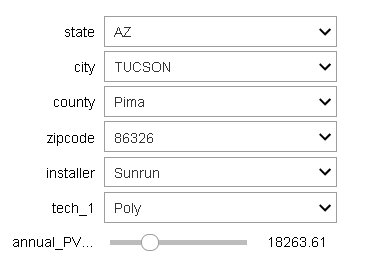

In [21]:
display(Image(filename='Thanos.png', embed=True))

In [22]:
Thanos = solarpanel_size_cost_breakeven('Thanos', p4)
Thanos

======================================= Thanks for opting solar energy dear Thanos ==================================


■ Thanos needs solar panel of size 11.52kw to replace total annual traditional energy consumption of 18264.61kwh


■ Thanos needs to invest $26385.98 to install solar panels of size 11.52kw


■ Thanos needs 21.0 years to break even for his investment to switch from traditional to solar energy.


,annual_PV_prod,size_kw,predicted_cost
Thanos,18264.61,11.522657,26385.980537


■ Next step is to add a DASH based app. <br>
→ It might be also difficult to spend ~26k at one shot based on the person's economic situation. So in app I would like to give the option to what % the person wants to convert to solar energy. For example- if he wants to use only 20% of his energy from solar power then he need less solar panels (solar panel size) and thus he will have to spend less money. This can act as a batch test and if it works for the person in question he can slowly transition more towards solar energy. 